In [1]:
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import matplotlib.dates as mdates
import pandas as pd

Connecting austin@datajoint-rds.cyuksi65nrdq.us-east-1.rds.amazonaws.com:3306


In [2]:
from psychofit import psychofit as psy

In [3]:
from behavior_plots import *
from load_mouse_data import *

Connected to https://alyx.internationalbrainlab.org as vathes


In [4]:
ibl17 = (subject.Subject() & 'subject_nickname = "IBL_17"').fetch1()

In [ ]:
def fix_date_axis(ax):
    # deal with date axis and make nice looking 
    ax.xaxis_date()
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    for item in ax.get_xticklabels():
        item.set_rotation(60)

## Weight over time

In [ ]:
wei = {}
wei['date_time'], wei['weight'] = (action.Weighing() & ibl17).fetch('weighing_time', 'weight', order_by='weighing_time')

In [ ]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
sns.lineplot(x="date_time", y="weight", color="black", markers=True, data=wei, ax=ax)
sns.scatterplot(x="date_time", y="weight", color="black", data=wei, ax=ax)
ax.set(xlabel='', ylabel="Weight (g)", 
xlim=[wei['date_time'].min()-timedelta(days=1), wei['date_time'].max()+timedelta(days=1)])
fix_date_axis(ax)

## Water intake

In [25]:
def get_water(mousename):
    w = (action.WaterAdministration() & ibl17).fetch(as_dict=True)
    w = pd.DataFrame(w)
    w.rename(columns={'administration_time':'date_time'}, inplace=True)
    wei['date_time'] = pd.to_datetime(wei.date_time)
    w.sort_values('date_time', inplace=True)
    wei.reset_index(drop=True, inplace=True)
    w['date'] = w['date_time'].dt.floor('D')
    w['days'] = w.date - w.date[0]
    w['days'] = w.days.dt.days
    w = w.set_index('date')
    w.index = pd.to_datetime(w.index)
    wa_unstacked = w.pivot_table(index='date', 
        columns='watertype_name', values='water_administered', aggfunc='sum').reset_index()
    wa_unstacked['date'] = pd.to_datetime(wa_unstacked.date)
    wa_unstacked.set_index('date', inplace=True)
    return wa_unstacked, w

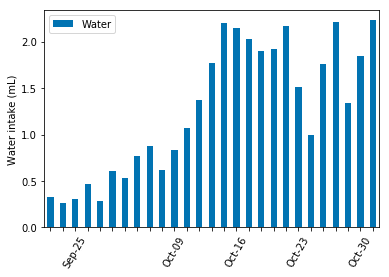

In [30]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
sns.set_palette("colorblind") # palette for water
wa_unstacked, wa = get_water(ibl17)
wa_unstacked.loc[:,['Water']].plot.bar(stacked=True, ax=ax)
l = ax.legend()
l.set_title('')
ax.set(ylabel="Water intake (mL)", xlabel='')

# fix dates, known to be an issue in pandas/matplotlib
ax.set_xticklabels([dt.strftime('%b-%d') if dt.weekday() is 1 else "" for dt in wa_unstacked.index.to_pydatetime()])
for item in ax.get_xticklabels():
    item.set_rotation(60)